# Gravity Train

We will calculate the time taken by a gravity train while journeying through different straight line paths through the earth. We start by defining some constants that we will be using in the calculations.

In [1]:
%matplotlib inline
# above line needs to be the first line in the notebook
# it is required to show inline matplotlib plots.

# we will use these imports in the code below
import matplotlib.pyplot as plt
import math
from pprint import pprint as pp

# constants
dia = 12742000 # diameter of the earth in meters
rad = dia/2.0
me = 5.972e24  # mass of the earth in kg
pi = 3.1415926
G = 6.67384e-11 # gravitational constant
g = 9.8

volume = 4 * pi * pow(rad, 3.0) / 3.0
density = me / volume

#### Acceleration vs Distance from center of the earth (uniform density)
It will be interesting to see in a graphical form, how the acceleration due to gravity varies by depth as one goes deeper into the earth. Lets calculate and plot this first. From our analytical work ($a_h = \frac {h}{R} g$), its expected to be a linear relationship (so its not all that interesting after all).

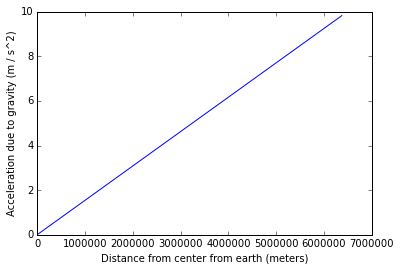

In [2]:
def calc_acc_at_depth(d):
    """
    returns the acceleration at distance d
    from the center of the earth, assuming 
    uniform density
    """
    if d > rad:
        return g
    if d < -rad:
        return -g
    vol_d = 4 * pi * pow(d, 3.0) / 3.0
    md = density * vol_d
    acc = G*md / pow(d, 2.0)
    return acc

acc_at_depth = []
for d in xrange(500, 1, -1):
    dd = d*rad / 500
    acc_at_depth.append((dd, calc_acc_at_depth(dd)))

xvals = [a for a,b in acc_at_depth]
yvals = [b for a,b in acc_at_depth]
plt.xlabel("Distance from center from earth (meters)")
plt.ylabel("Acceleration due to gravity (m / s^2)")
plt.plot(xvals, yvals)



The above graph is, as expected, a straight line, though there was hardly any doubt about that outcome.

Next, we will calculate and plot the travel time for 127 different tunnel lengths, uniformly distributed in their length, starting from 100 km and going up to 12700 km (almost equal to the diameter).

Difference between max and min travel times : 2.69295696853e-12


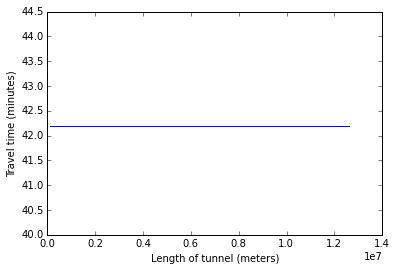

In [3]:
chord_lengths = [100000*n for n in range(1, 127)]

def get_acc(chlen, R, x):
    """
    return acceleration at distance x
    into a tunnel of length chlen
    """
    return (g/(2*R))*(chlen - 2*x)

def get_vt(s, v, a):
    """
    Given the current velocity, acceleration a distance 's',
    returns the velocity after train covers the distance 's'
    and the time take to cover the distance.
    """
    rv = rt = 0
    if a == 0:
        rv = v
        rt = s/v
        return (rv, rt)
    rt = (math.sqrt(v*v + 2*a*s) - v) / a
    rv = v + a*rt
    return (rv, rt)
        
def get_travel_time(chlen, nparts, acc_func):
    """
    returns the total travel time for traversing the
    tunnel, from beginning to end
    """
    dist = chlen/2.0
    curve_power = 2.0
    stfacs = [pow((float(x)/nparts), curve_power) for x in xrange(nparts+1)]
    steps = [dist*xx for xx in stfacs]
    total_time = 0
    cv = 0
    for st1, st2 in zip(steps, steps[1:]):
        dist = st2 - st1
        acc = acc_func(chlen, rad, st1)
        cv, time_part = get_vt(dist, cv, acc)
        total_time += time_part
        
    return 2*total_time

results = [(dist1, get_travel_time(dist1, 500, get_acc)) for dist1 in chord_lengths]

# plot of time vs chord length
yvals = [t/60.0 for d, t in results]
maxDiff = max(yvals) - min(yvals)

yvals = [float("%10.6f" % t) for t in yvals]
xvals = [d for d, t in results]
plt.xlabel("Length of tunnel (meters)")
plt.ylabel("Travel time (minutes)")
plt.plot(xvals, yvals)

print "Difference between max and min travel times : %s" % maxDiff

*All right!* This confirms our analytical solution. The travel time across chords of different length are indeed almost exactly the same. The differences in the max and min travel times is of the order of $10^{-11}$, which is probably the best accuracy that we can get with double precision arithmetic on a computer.

This is all well and good for the simplified case of the earth having uniform density. But that is not true for the real earth. In fact, we expect the density near the core to be larger due to the pressure of all the mass that is pressing down upon it.


#### Acceleration in non-uniform density

This website (http://geophysics.ou.edu/solid_earth/prem.html) gives us a table of acceleration vs depth for the earth.

I copy pasted the table and cleaned up the data in a few lines of code below (python is awesome).

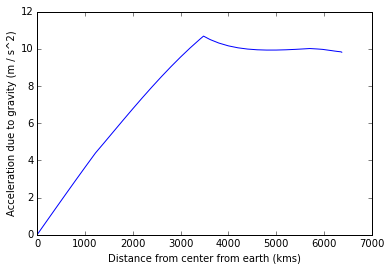

In [4]:
# depth vs acceleration table from
# http://geophysics.ou.edu/solid_earth/prem.html

g_at_depth = """0.0	11266.20	3667.80	13088.48	1425.3	176.1	0.4407	363.850	0.0000
200.0	11255.93	3663.42	13079.77	1423.1	175.5	0.4408	362.900	0.7311
400.0	11237.12	3650.27	13053.64	1416.4	173.9	0.4410	360.030	1.4604
600.0	11205.76	3628.35	13010.09	1405.3	171.3	0.4414	355.280	2.1862
800.0	11161.86	3597.67	12949.12	1389.8	167.6	0.4420	348.670	2.9068
1000.0	11105.42	3558.23	12870.73	1370.1	163.0	0.4428	340.240	3.6203
1200.0	11036.43	3510.02	12774.93	1346.2	157.4	0.4437	330.050	4.3251
1221.5	11028.27	3504.32	12763.60	1343.4	156.7	0.4438	328.850	4.4002
1400.0	10249.59	0.00	12069.24	1267.9	0.0	0.5000	318.750	4.9413
1600.0	10122.91	0.00	11946.82	1224.2	0.0	0.5000	306.150	5.5548
1800.0	9985.54	0.00	11809.00	1177.5	0.0	0.5000	292.220	6.1669
2000.0	9834.96	0.00	11654.78	1127.3	0.0	0.5000	277.040	6.7715
2200.0	9668.65	0.00	11483.11	1073.5	0.0	0.5000	260.680	7.3645
2400.0	9484.09	0.00	11292.98	1015.8	0.0	0.5000	243.250	7.9425
2600.0	9278.76	0.00	11083.35	954.2	0.0	0.5000	224.850	8.5023
2800.0	9050.15	0.00	10853.21	888.9	0.0	0.5000	205.600	9.0414
3000.0	8795.73	0.00	10601.52	820.2	0.0	0.5000	185.640	9.5570
3200.0	8512.98	0.00	10327.26	748.4	0.0	0.5000	165.120	10.0464
3400.0	8199.39	0.00	10029.40	674.3	0.0	0.5000	144.190	10.5065
3480.0	8064.82	0.00	9903.49	644.1	0.0	0.5000	135.750	10.6823
3600.0	13687.53	7265.75	5506.42	644.0	290.7	0.3038	128.710	10.5204
3630.0	13680.41	7265.97	5491.45	641.2	289.9	0.3035	126.970	10.4844
3800.0	13447.42	7188.92	5406.81	609.5	279.4	0.3012	117.350	10.3095
4000.0	13245.32	7099.74	5307.24	574.4	267.5	0.2984	106.390	10.1580
4200.0	13015.79	7010.53	5207.13	540.9	255.9	0.2957	95.760	10.0535
4400.0	12783.89	6919.57	5105.90	508.5	244.5	0.2928	85.430	9.9859
4600.0	12544.66	6825.12	5002.99	476.6	233.1	0.2898	75.360	9.9474
4800.0	12293.16	6725.48	4897.83	444.8	221.5	0.2864	65.520	9.9314
5000.0	12024.45	6618.91	4789.83	412.8	209.8	0.2826	55.900	9.9326
5200.0	11733.57	6563.70	4678.44	380.3	197.9	0.2783	46.490	9.9467
5400.0	11415.60	6378.13	4563.07	347.1	185.6	0.2731	37.290	9.9698
5600.0	11065.57	6240.46	4443.17	313.3	173.0	0.2668	28.290	9.9985
5701.0	10751.31	5945.08	4380.71	299.9	154.8	0.2798	23.830	10.0143
5771.0	10157.82	5516.01	3975.84	248.9	121.0	0.2909	21.040	10.0038
5701.0	10751.31	5945.08	4380.71	299.9	154.8	0.2798	23.830	10.0143
5771.0	10157.82	5516.01	3975.84	248.9	121.0	0.2909	21.040	10.0038
5871.0	9645.88	5224.28	3849.80	218.1	105.1	0.2924	17.130	9.9883
5971.0	9133.97	4932.59	3723.78	189.9	90.6	0.2942	13.350	9.9686
6061.0	8732.09	4706.90	3489.51	163.0	77.3	0.2952	10.200	9.9361
6151.0	8558.96	4643.91	3435.78	152.9	74.1	0.2914	7.110	9.9048
6221.0	8033.70	4443.61	3367.10	128.7	66.5	0.2796	4.780	9.8783
6291.0	8076.88	4469.53	3374.71	130.3	67.4	0.2793	2.450	9.8553
6346.6	8110.61	4490.94	3380.76	131.5	68.2	0.2789	0.604	9.8394
6356.0	6800.00	3900.00	2900.00	75.3	44.1	0.2549	0.337	9.8332
6368.0	5800.00	3200.00	2600.00	52.0	26.6	0.2812	0.300	9.8222
6371.0	1450.00	0.00	1020.00	2.1	0.0	0.5000	0.000	9.8156"""

g_at_depth = g_at_depth.strip().split("\n")
g_at_depth = [d.split("\t") for d in g_at_depth]
g_at_depth = [(float(d[0]), float(d[-1])) for d in g_at_depth]
g_at_depth = sorted(set(g_at_depth))

xvals = [d for d, g in g_at_depth]
yvals = [g for d, g in g_at_depth]
plt.xlabel("Distance from center from earth (kms)")
plt.ylabel("Acceleration due to gravity (m / s^2)")
plt.plot(xvals, yvals)


The PREM data only gives the acceleration at discrete intervals. We will write an interpolation method which will do a linear interpolation of the acceleration based on the PREM table.

After doing that, we can find the travel times for different chord lengths and plot it.

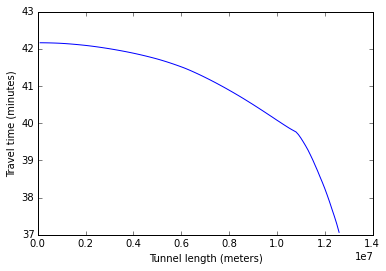

In [5]:
# find correct acceleration at varying depths
dtable = [d for d, g in g_at_depth]
gtable = [g for d, g in g_at_depth]

from bisect import bisect_left

def get_real_acc_at_depth(depth):
    """
    using linear interpolation of the PREM table, find the
    acceleration due to gravity at given depth and return it.
    """
    
    idx = bisect_left(dtable, depth)
    if idx == len(dtable) - 1:
        return gtable[-1]
    gl, gh = gtable[idx], gtable[idx+1]
    dl, dh = dtable[idx], dtable[idx+1]
    fac = (d - dl)/(dh - dl)
    rg = gl + fac*(gh - gl)
    return rg
    
def get_actual_acc(chlen, R, x):
    """
    return real world acceleration at distance x
    into a tunnel of length chlen
    """
    depth = math.sqrt(R*R + x*x - chlen*x)
    gd = get_real_acc_at_depth(depth/1000.0)
    return (gd/(2*depth))*(chlen - 2*x)



results = [(dist1, get_travel_time(dist1, 500, get_actual_acc)) for dist1 in chord_lengths]

# plot of time vs chord length
xvals = [d for d, t in results]
yvals = [t/60.0 for d, t in results]
plt.xlabel("Tunnel length (meters)")
plt.ylabel("Travel time (minutes)")
plt.plot(xvals, yvals)
    

## Whoa.... this is damn cool!

The graph above shows that we can travel to the opposite side of the earth in ~37 minutes, while it takes 42 minutes to travel to nearby places. This is the kind of result that makes one fall in love with physics and maths.

Maybe someday, we can find such a shortcut through space which allows us to jump to far away galaxies faster than we can travel in our own solar system.

If you look closely, you will also see that this is the essence of gravity assisted slingshot mechanisms that space rockets use to their advantage for gaining speed and venturing into outer space.